In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from IPython.display import Latex, display
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import time
import emcee
import seaborn as sns
from matplotlib.lines import Line2D
import dynesty
import multiprocessing
import corner
from dynesty import utils as dyfunc
from scipy.stats import gaussian_kde

In [2]:
# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix
# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values

# Speed of light in km/s
c_km_s = 299792.458

/var/tmp/stamou/ipykernel_2749104/945048711.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


# MCMC Sampling via emcee
## No-transition

In [3]:
def E_w0CDM(z, Omega_m, w0):
    """Dimensionless Hubble parameter E(z) = H(z)/H0 for flat w0CDM."""
    Omega_Lambda = 1.0 - Omega_m
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda * (1 + z)**(3 * (1 + w0)))

@lru_cache(maxsize=None)
def integral_dL_w0CDM(z, H0, Omega_m, w0):
    """Luminosity distance integral for w0CDM with caching."""
    integrand = lambda zp: 1.0 / E_w0CDM(zp, Omega_m, w0)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory_w0CDM(z_array, H0, Omega_m, w0):
    """Compute theoretical distance modulus for an array of z in w0CDM."""
    return np.array([
        5 * np.log10(integral_dL_w0CDM(float(z), H0, Omega_m, w0)) + 25
        for z in z_array
    ])


# --- Chi-Square Function for w0CDM ---
def chi2(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    """
    Compute chi2 using modified residual vector Q' for the w0CDM model.
    """
    M, H0, Omega_m, w0 = params
    mu_model = mu_theory_w0CDM(z, H0, Omega_m, w0)

    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(
            z >= 0.0,  
            mB - M - mu_model,
            0.0  
        )
    )

    return Q.T @ C_inv @ Q

# --- Priors for w0CDM ---
priors = {
    'M': (-20.0, -18.0),         # Absolute magnitude of SNeIa
    'H0': (65.0, 78.0),          # Hubble constant in km/s/Mpc
    'Omega_m': (0.1, 0.8),       # Matter density parameter
    'w0': (-1.3, 0.0)            # Dark energy equation-of-state parameter
}

# --- Log-Posterior Function for w0CDM ---
def log_posterior(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    
    M, H0, Omega_m, w0 = params
    
    # Unpack prior bounds
    M_min, M_max = priors['M']
    H0_min, H0_max = priors['H0']
    Omega_m_min, Omega_m_max = priors['Omega_m']
    w0_min, w0_max = priors['w0']
    
    # Flat priors (hard boundaries)
    if not (M_min <= M <= M_max and H0_min <= H0 <= H0_max and 
            Omega_m_min <= Omega_m <= Omega_m_max and w0_min <= w0 <= w0_max):
        return -np.inf  # Reject proposals outside bounds

    chi2_val = chi2(params, z, mB, mu_Ceph, is_calibrator, C_inv)
    
    return -0.5 * chi2_val



In [5]:
import time
import numpy as np
import emcee
import multiprocessing
import pickle  # <-- for saving the sampler

# --- MCMC with emcee for w0CDM ---
def run_emcee(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
              n_walkers=32, n_steps=5000, burn_in=1000):

    ndim = 4  # Number of parameters (M, H0, Omega_m, w0)

    # --- Initialize walkers ---
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['Omega_m']),
            np.random.uniform(*priors['w0'])
        ]
        for _ in range(n_walkers)
    ])

    # --- Set up multiprocessing pool ---
    with multiprocessing.get_context("fork").Pool() as pool:
        # --- Define sampler ---
        sampler = emcee.EnsembleSampler(
            n_walkers,
            ndim,
            log_posterior,
            args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors),
            pool=pool
        )

        # --- Run MCMC ---
        sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # --- Get flattened chain (after burn-in) ---
    samples = sampler.get_chain(discard=burn_in, flat=True)

    # ✅ Save flattened samples
    np.save("samples_chain_w0CDM_5000steps.npy", samples)

    # ✅ Save full raw chain for diagnostics
    full_chain = sampler.get_chain()
    np.save("full_sampler_chain_w0CDM_5000steps.npy", full_chain)

    # ✅ Save the full sampler object
    with open("sampler_w0CDM.pkl", "wb") as f:
        pickle.dump(sampler, f)

    return samples, sampler

# --- Run the sampler for w0CDM ---
start_time = time.time()

samples, sampler = run_emcee(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors,
    n_walkers=32,
    n_steps=5000,
    burn_in=1000
)

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


100%|█████████████████████████████████████| 5000/5000 [3:43:54<00:00,  2.69s/it]


⏱️ Execution time: 13444.83 seconds


In [6]:
import numpy as np
import pickle

# Load sampler object
with open("Saved Samples/sampler_w0CDM.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Compute autocorrelation time ---
try:
    tau = sampler.get_autocorr_time(tol=0)  # more stable estimate
    print("Autocorrelation time per parameter:")
    for i, t in enumerate(tau):
        print(f"  Param {i}: τ = {t:.1f} steps")

    # --- Compute effective sample size ---
    n_walkers, n_steps, ndim = sampler.chain.shape
    n_eff = n_walkers * n_steps / tau
    print("\nEffective sample size per parameter:")
    for i, n in enumerate(n_eff):
        print(f"  Param {i}: N_eff ≈ {int(n):,}")
except emcee.autocorr.AutocorrError:
    print("⚠️ Autocorrelation time could not be reliably estimated. Consider running longer chains.")


Autocorrelation time per parameter:
  Param 0: τ = 41.4 steps
  Param 1: τ = 49.1 steps
  Param 2: τ = 80.0 steps
  Param 3: τ = 77.8 steps

Effective sample size per parameter:
  Param 0: N_eff ≈ 3,862
  Param 1: N_eff ≈ 3,255
  Param 2: N_eff ≈ 2,000
  Param 3: N_eff ≈ 2,056


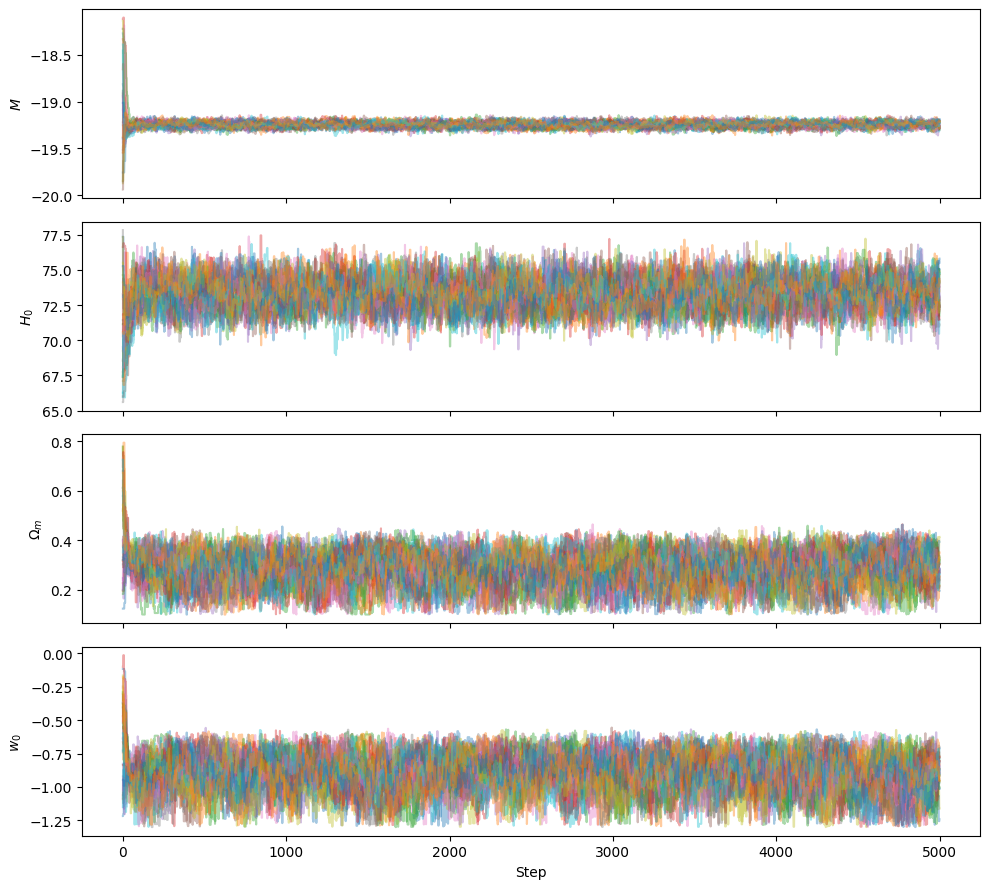

In [12]:
# Load samples and full chain for w0CDM
samples = np.load("Saved Samples/samples_chain_w0CDM_5000steps.npy")
full_chain = np.load("Saved Samples/full_sampler_chain_w0CDM_5000steps.npy")

# Update parameter labels for w0CDM
param_labels = [r"$M$", r"$H_0$", r"$\Omega_m$", r"$w_0$"]

# Create subplots: one row per parameter
fig, axes = plt.subplots(4, figsize=(10, 9), sharex=True)

# Plot walker chains for each parameter
for i in range(4):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4)
    axes[i].set_ylabel(param_labels[i])

axes[-1].set_xlabel("Step")
plt.tight_layout()

# Save to file
fig.savefig("chain_plot_w0CDM.png", dpi=300)
plt.show()

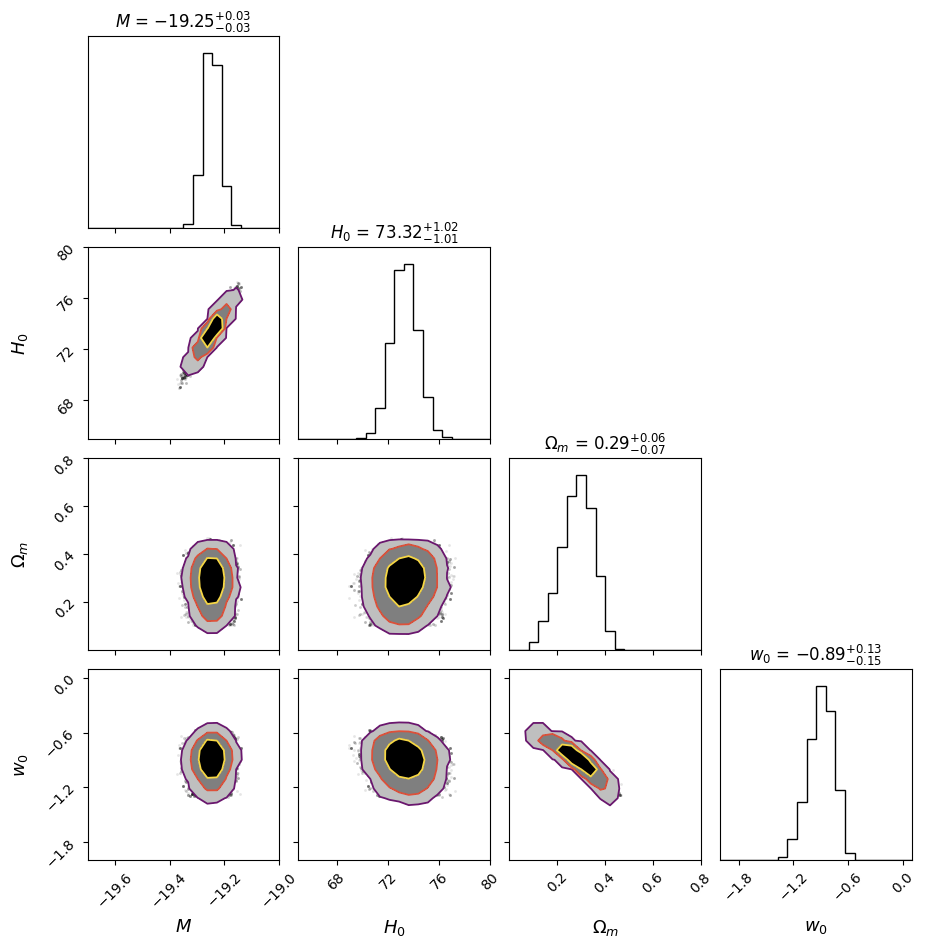

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
from IPython.display import display, Math

# Load samples
samples = np.load("Saved Samples/samples_chain_w0CDM_5000steps.npy")

# Updated parameter labels
param_labels = [r"$M$", r"$H_0$", r"$\Omega_m$", r"$w_0$"]

# Define contour levels for 1σ, 2σ, 3σ
levels = [0.68, 0.95, 0.997]

# Color styling
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]

# Ranges for each parameter (update as appropriate)
ranges = [
    (-19.7, -19.0),  # M
    (65, 80),        # H0
    (0.0, 0.8),      # Omega_m
    (-2.0, 0.1)     # w0
]

# Plot corner plot
fig_no = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# Save to file
fig_no.savefig("corner_plot_w0CDM.png", dpi=300)
plt.show()# Parameter labels (LaTeX-style) and units
param_labels_latex = [r"M", r"H_0", r"\Omega_m", r"w_0"]
units = ["", r"\,\mathrm{km/s/Mpc}", "", ""]

# Compute medians and 68% credible intervals
medians = np.median(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)

# Display LaTeX-formatted output
display(Math(r"\textbf{Posterior medians with 68\% credible intervals:}"))
for label, med, low, up, unit in zip(param_labels_latex, medians, lower, upper, units):
    err_minus = med - low
    err_plus = up - med
    display(Math(rf"{label} = {med:.3f}^{{+{err_plus:.3f}}}_{{-{err_minus:.3f}}}{unit}"))


In [5]:
import numpy as np
import pickle

# Load samples and sampler
samples = np.load("Saved Samples/samples_chain_w0CDM_5000steps.npy")
with open("Saved Samples/sampler_w0CDM.pkl", "rb") as f:
    sampler = pickle.load(f)

# Flattened log-probabilities (after burn-in)
log_prob = sampler.get_log_prob(discard=1000, flat=True)
flat_samples = sampler.get_chain(discard=1000, flat=True)

# MAP and median
map_index = np.argmax(log_prob)
map_params = flat_samples[map_index]
median_params = np.median(flat_samples, axis=0)

# Mean and 1σ uncertainty
means = np.mean(flat_samples, axis=0)
lower = np.percentile(flat_samples, 16, axis=0)
upper = np.percentile(flat_samples, 84, axis=0)
uncertainties = 0.5 * (upper - lower)

# Parameter names and units
param_names = ["M", "H0", "Omega_m", "w0"]
units = ["", "km/s/Mpc", "", ""]

# Print header
print(f"{'Parameter':<13} {'MAP':>10} {'Median':>10} {'Mean':>10} {'±1σ':>12} {'Unit':>10}")
print("-" * 65)

# Print values
for name, map_val, med_val, mean, err, unit in zip(param_names, map_params, median_params, means, uncertainties, units):
    print(f"{name:<13} {map_val:>10.4f} {med_val:>10.4f} {mean:>10.4f} ±{err:>6.4f} {unit:>10}")


Parameter            MAP     Median       Mean          ±1σ       Unit
-----------------------------------------------------------------
M               -19.2464   -19.2470   -19.2471 ±0.0290           
H0               73.3447    73.3185    73.3255 ±1.0130   km/s/Mpc
Omega_m           0.2880     0.2871     0.2825 ±0.0682           
w0               -0.8897    -0.8895    -0.8982 ±0.1416           


# Transition in $M$

In [4]:
def chi2_transition_w0CDM(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M_low, M_high, H0, Omega_m, w0, d_crit = params

    # Theoretical distance modulus from w0CDM
    mu_model = mu_theory_w0CDM(z, H0, Omega_m, w0)

    # Use apparent magnitude to calculate SH0ES-based distance modulus
    mu_SH0ES = mB + 19.253  # SH0ES fixed M = -19.253
    mu_crit = 5 * np.log10(d_crit) + 25

    # Assign M_low or M_high depending on location relative to d_crit
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    # Construct Q vector
    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        np.where(z >= 0.0, mB - M_used - mu_model, 0.0)
    )
    return Q.T @ C_inv @ Q


# --- Priors for w0CDM with transition in M ---
priors_w0CDM_transition = {
    'M_low': (-20.0, -18.0),       # M< for nearby SNe
    'M_high': (-20.0, -18.0),      # M> for distant SNe
    'H0': (65.0, 78.0),            # Hubble constant
    'Omega_m': (0.1, 0.8),         # Matter density
    'w0': (-1.3, 0.0),             # Equation of state (constant)
    'd_crit': (15.0, 25.0)         # Critical distance (Mpc)
}

def log_posterior_w0CDM_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    M_low, M_high, H0, Omega_m, w0, d_crit = params

    # --- Check parameter bounds (flat priors) ---
    if not (priors['M_low'][0] <= M_low <= priors['M_low'][1] and
            priors['M_high'][0] <= M_high <= priors['M_high'][1] and
            priors['H0'][0] <= H0 <= priors['H0'][1] and
            priors['Omega_m'][0] <= Omega_m <= priors['Omega_m'][1] and
            priors['w0'][0] <= w0 <= priors['w0'][1] and
            priors['d_crit'][0] <= d_crit <= priors['d_crit'][1]):
        return -np.inf

    # --- Compute chi-square ---
    chi2 = chi2_transition_w0CDM(
        params, z, mB, mu_Ceph, is_calibrator, C_inv
    )

    return -0.5 * chi2

In [5]:
import numpy as np
import emcee
import multiprocessing
import pickle
import time

# --- MCMC with emcee for w0CDM transition model ---
def run_emcee_w0CDM_transition(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
                                n_walkers=32, n_steps=5000, burn_in=1000):

    ndim = 6  # Parameters: M_low, M_high, H0, Omega_m, w0, d_crit

    # --- Initialize walkers within prior bounds ---
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M_low']),
            np.random.uniform(*priors['M_high']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['Omega_m']),
            np.random.uniform(*priors['w0']),
            np.random.uniform(*priors['d_crit'])
        ]
        for _ in range(n_walkers)
    ])

    # --- Set up multiprocessing pool ---
    with multiprocessing.get_context("fork").Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers,
            ndim,
            log_posterior_w0CDM_transition,
            args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors),
            pool=pool
        )

        sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # --- Flattened chain (after burn-in) ---
    samples = sampler.get_chain(discard=burn_in, flat=True)

    # ✅ Save flattened samples
    np.save("samples_chain_w0CDM_transition_5000steps.npy", samples)

    # ✅ Save full raw chain
    full_chain = sampler.get_chain()
    np.save("full_sampler_chain_w0CDM_transition_5000steps.npy", full_chain)

    # ✅ Save full sampler object
    with open("sampler_w0CDM_transition.pkl", "wb") as f:
        pickle.dump(sampler, f)

    return samples, sampler

# --- Run the sampler ---
start_time = time.time()

samples_transition, sampler_transition = run_emcee_w0CDM_transition(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors_w0CDM_transition,
    n_walkers=32,
    n_steps=5000,
    burn_in=1000
)


100%|█████████████████████████████████████| 5000/5000 [3:41:21<00:00,  2.66s/it]


In [8]:
import numpy as np
import pickle
import emcee

# Load the transition sampler
with open("sampler_w0CDM_transition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Try autocorrelation and effective sample size ---
try:
    tau = sampler.get_autocorr_time(tol=0)
    param_names = ["M_low", "M_high", "H0", "Omega_m", "w0", "d_crit"]

    print("Autocorrelation time per parameter:")
    for name, t in zip(param_names, tau):
        print(f"  {name:<8s}: τ = {t:.1f} steps")

    # Compute effective sample sizes
    n_walkers, n_steps, ndim = sampler.chain.shape
    n_eff = (n_walkers * n_steps) / tau

    print("\nEffective sample size per parameter:")
    for name, n in zip(param_names, n_eff):
        print(f"  {name:<8s}: N_eff ≈ {int(n):,}")

except emcee.autocorr.AutocorrError:
    print("⚠️ Autocorrelation time could not be reliably estimated. Consider increasing n_steps.")


Autocorrelation time per parameter:
  M_low   : τ = 74.0 steps
  M_high  : τ = 73.7 steps
  H0      : τ = 93.6 steps
  Omega_m : τ = 125.1 steps
  w0      : τ = 126.8 steps
  d_crit  : τ = 105.4 steps

Effective sample size per parameter:
  M_low   : N_eff ≈ 2,162
  M_high  : N_eff ≈ 2,172
  H0      : N_eff ≈ 1,710
  Omega_m : N_eff ≈ 1,278
  w0      : N_eff ≈ 1,262
  d_crit  : N_eff ≈ 1,517


In [9]:
import numpy as np
import pickle

# --- Load samples and sampler ---
samples = np.load("samples_chain_w0CDM_transition_5000steps.npy")
with open("sampler_w0CDM_transition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Extract log-probabilities (after burn-in) ---
log_prob = sampler.get_log_prob(discard=1000, flat=True)
flat_samples = sampler.get_chain(discard=1000, flat=True)

# --- MAP and median ---
map_index = np.argmax(log_prob)
map_params = flat_samples[map_index]
median_params = np.median(flat_samples, axis=0)

# --- Mean and 1σ uncertainty ---
means = np.mean(flat_samples, axis=0)
lower = np.percentile(flat_samples, 16, axis=0)
upper = np.percentile(flat_samples, 84, axis=0)
uncertainties = 0.5 * (upper - lower)

# --- Parameter names and units ---
param_names = ["M_low", "M_high", "H0", "Omega_m", "w0", "d_crit"]
units = ["", "", "km/s/Mpc", "", "", "Mpc"]

# --- Print formatted results ---
print(f"{'Parameter':<15} {'MAP':>10} {'Median':>10} {'Mean':>10} {'±1σ':>12} {'Unit':>10}")
print("-" * 70)

for name, map_val, med_val, mean, err, unit in zip(param_names, map_params, median_params, means, uncertainties, units):
    print(f"{name:<15} {map_val:>10.4f} {med_val:>10.4f} {mean:>10.4f} ±{err:>6.4f} {unit:>10}")


Parameter              MAP     Median       Mean          ±1σ       Unit
----------------------------------------------------------------------
M_low             -19.3902   -19.3976   -19.3996 ±0.0559           
M_high            -19.2069   -19.2116   -19.2112 ±0.0308           
H0                 74.8037    74.5490    74.5676 ±1.0776   km/s/Mpc
Omega_m             0.3021     0.2978     0.2908 ±0.0688           
w0                 -0.9302    -0.9133    -0.9202 ±0.1519           
d_crit             19.9622    19.5856    19.7435 ±0.8934        Mpc


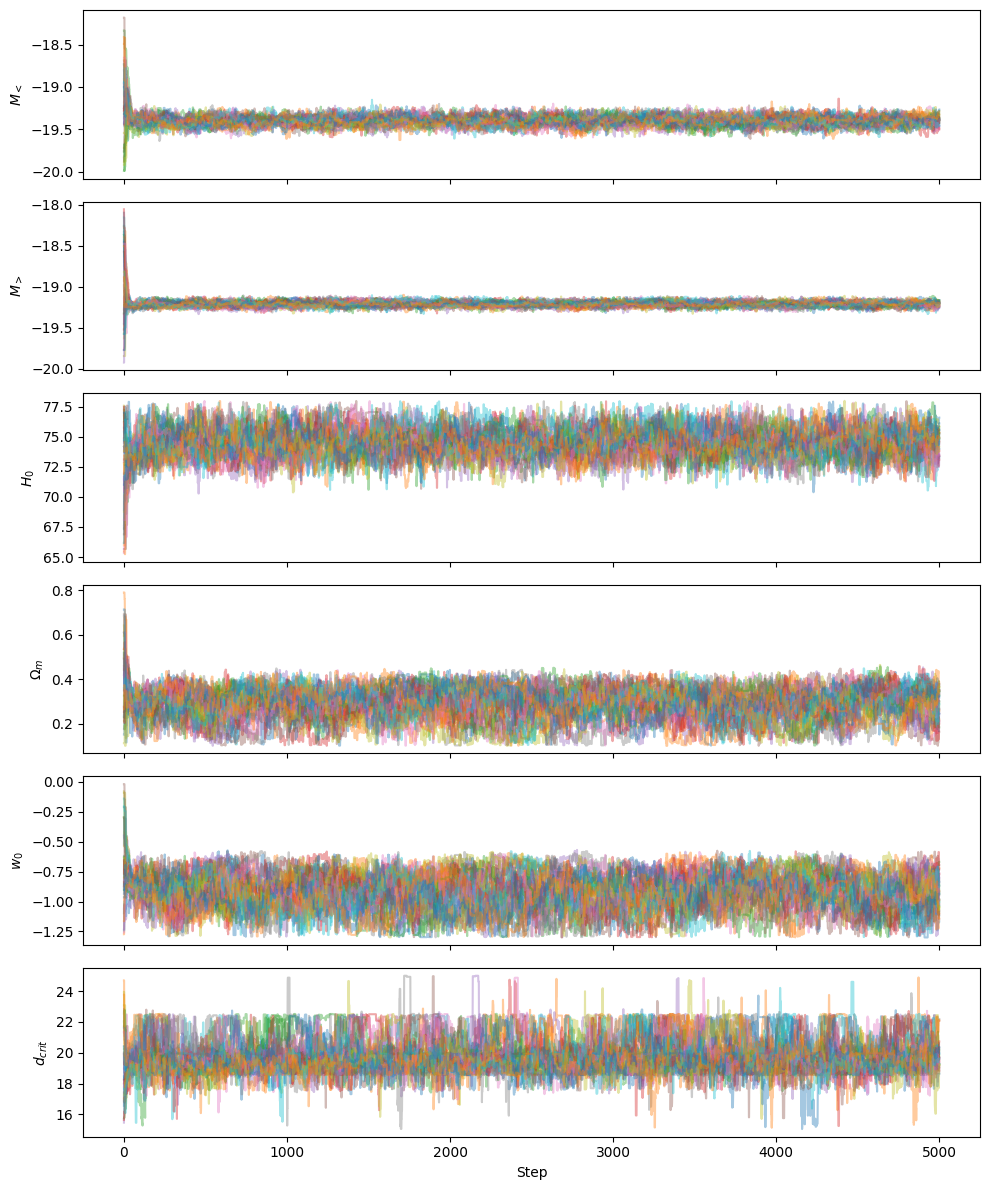

In [15]:
# --- Load samples and full chain ---
samples = np.load("samples_chain_w0CDM_transition_5000steps.npy")
full_chain = np.load("full_sampler_chain_w0CDM_transition_5000steps.npy")

# --- Parameter labels for w0CDM with transition ---
param_labels = [r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$d_{crit}$"]

# --- Create subplots: one row per parameter ---
fig, axes = plt.subplots(len(param_labels), figsize=(10, 12), sharex=True)

# --- Plot walker chains for each parameter ---
for i in range(len(param_labels)):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4)
    axes[i].set_ylabel(param_labels[i])

axes[-1].set_xlabel("Step")
plt.tight_layout()

# --- Save to file ---
fig.savefig("chain_plot_w0CDM_transition.png", dpi=300)
plt.show()


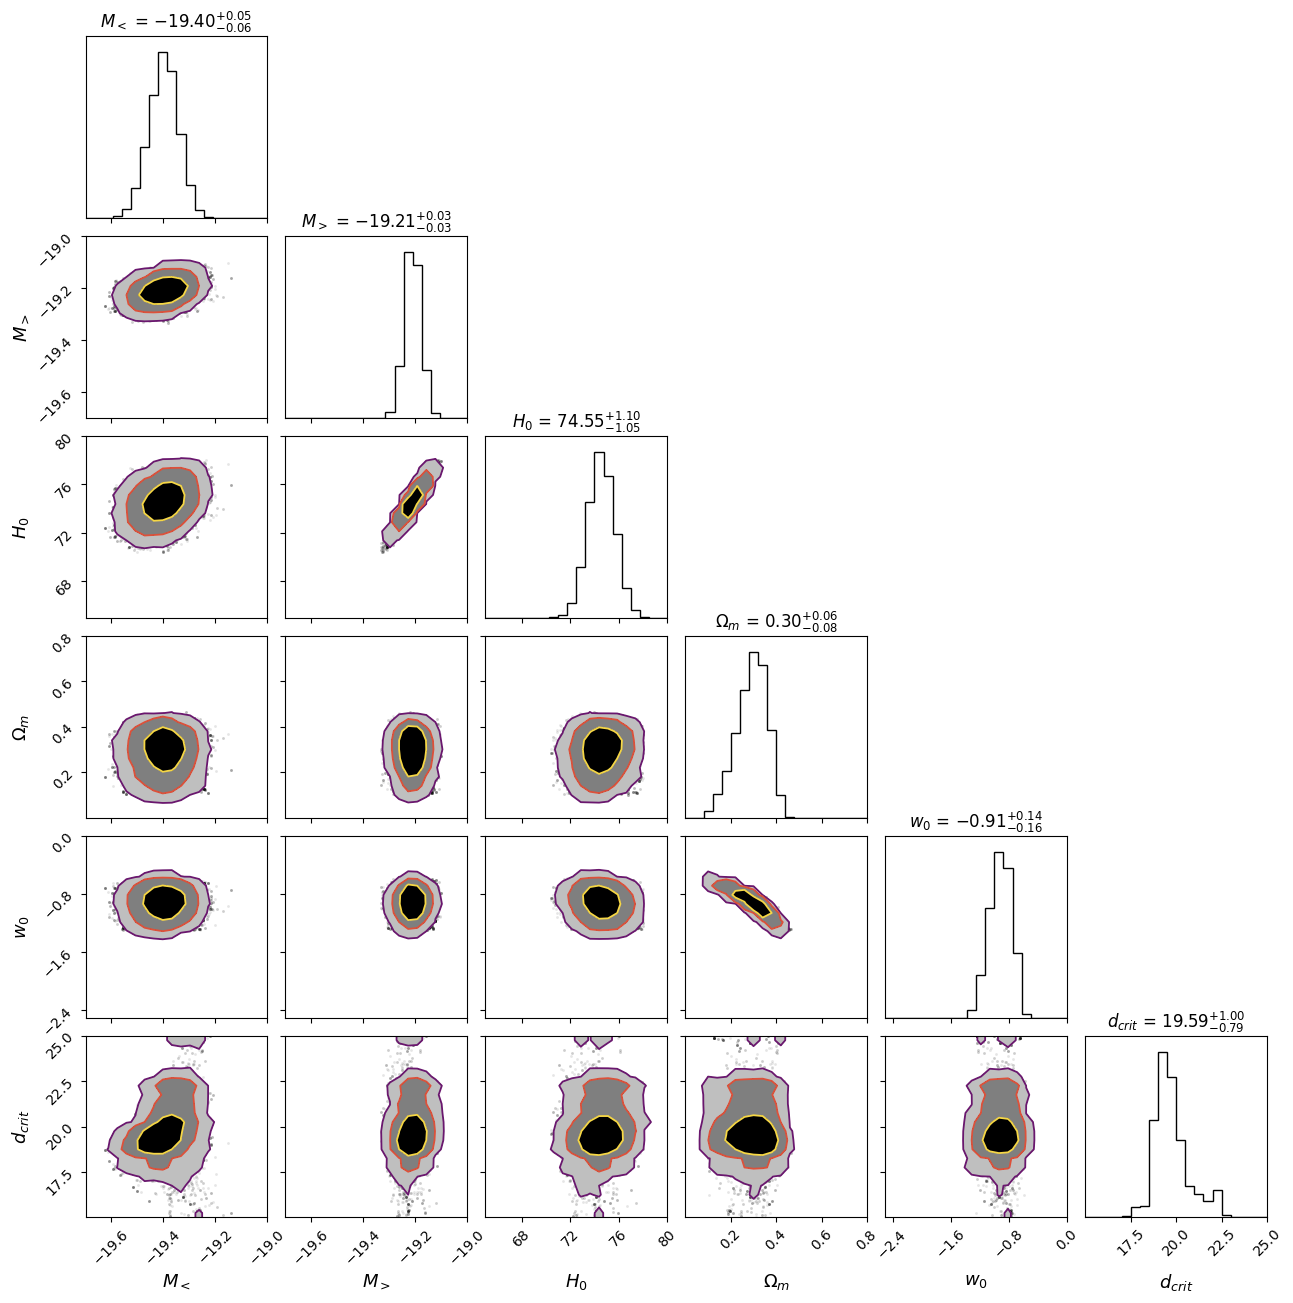

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from IPython.display import display, Math

# --- Load samples ---
samples = np.load("samples_chain_w0CDM_transition_5000steps.npy")

# --- Parameter labels (LaTeX-style) ---
param_labels = [r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$d_{crit}$"]

# --- Contour levels for 1σ, 2σ, 3σ ---
levels = [0.68, 0.95, 0.997]

# --- Color styling ---
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]

# --- Ranges for each parameter (adjust based on your sample spread if needed) ---
ranges = [
    (-19.7, -19.0),  # M_low
    (-19.7, -19.0),  # M_high
    (65, 80),        # H0
    (0.0, 0.8),      # Omega_m
    (-2.5, 0.0),     # w0
    (15, 25)         # d_crit in Mpc
]

# --- Plot corner plot ---
fig = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# --- Save to file ---
fig.savefig("corner_plot_w0CDM_transition.png", dpi=300)
plt.show()

# --- Compute and display medians and 68% credible intervals ---
param_labels_latex = ["M_{<}", "M_{>}", "H_0", r"\Omega_m", "w_0", "d_{crit}"]
units = ["", "", r"\,\mathrm{km/s/Mpc}", "", "", r"\,\mathrm{Mpc}"]

medians = np.median(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)

display(Math(r"\textbf{Posterior medians with 68\% credible intervals:}"))
for label, med, low, up, unit in zip(param_labels_latex, medians, lower, upper, units):
    err_minus = med - low
    err_plus = up - med
    display(Math(rf"{label} = {med:.3f}^{{+{err_plus:.3f}}}_{{-{err_minus:.3f}}}{unit}"))


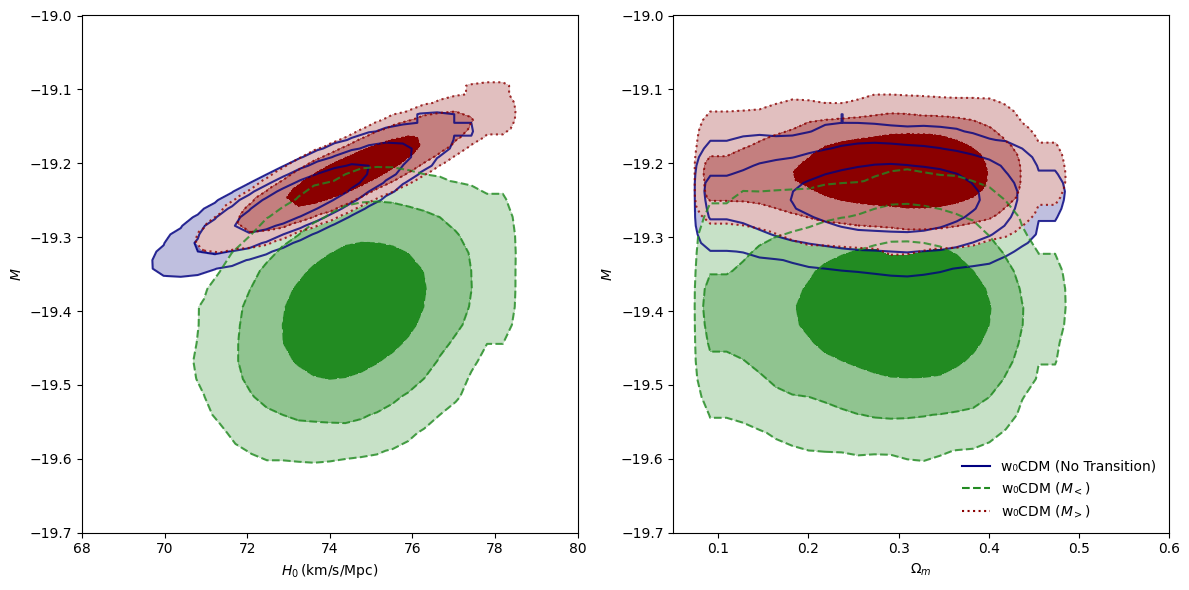

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# --- Load MCMC samples ---
samples_std = np.load("Saved Samples/samples_chain_w0CDM_5000steps.npy")
samples_trans = np.load("samples_chain_w0CDM_transition_5000steps.npy")

# --- Extract parameters ---
# Standard: M, H0, Omega_m, w0
M_std, H0_std, Om_std = samples_std[:, 0], samples_std[:, 1], samples_std[:, 2]

# Transition: M_low, M_high, H0, Omega_m, w0, d_crit
M_lt, M_gt = samples_trans[:, 0], samples_trans[:, 1]
H0_lt, Om_lt = samples_trans[:, 2], samples_trans[:, 3]

# --- Plot settings ---
h0_range = (68, 80)
om_range = (0.05, 0.60)
M_range = (-19.7, -19.0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ---------- Panel 1: M vs H0 ----------
corner.hist2d(H0_std, M_std, ax=axes[0], plot_datapoints=False,
              fill_contours=True, smooth=0.8, levels=(0.6827, 0.9545, 0.9973),
              color="navy",
              contour_kwargs={"linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.3})

corner.hist2d(H0_lt, M_lt, ax=axes[0], plot_datapoints=False,
              fill_contours=True, smooth=0.8, levels=(0.6827, 0.9545, 0.9973),
              color="forestgreen",
              contour_kwargs={"linestyles": "dashed", "linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.2})

corner.hist2d(H0_lt, M_gt, ax=axes[0], plot_datapoints=False,
              fill_contours=True, smooth=0.8, levels=(0.6827, 0.9545, 0.9973),
              color="darkred",
              contour_kwargs={"linestyles": "dotted", "linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.2})

axes[0].set_xlim(h0_range)
axes[0].set_ylim(M_range)
axes[0].set_xlabel(r"$H_0\,(\mathrm{km/s/Mpc})$")
axes[0].set_ylabel(r"$M$")

# ---------- Panel 2: M vs Omega_m ----------
corner.hist2d(Om_std, M_std, ax=axes[1], plot_datapoints=False,
              fill_contours=True, smooth=0.8, levels=(0.6827, 0.9545, 0.9973),
              color="navy",
              contour_kwargs={"linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.3})

corner.hist2d(Om_lt, M_lt, ax=axes[1], plot_datapoints=False,
              fill_contours=True, smooth=0.8, levels=(0.6827, 0.9545, 0.9973),
              color="forestgreen",
              contour_kwargs={"linestyles": "dashed", "linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.2})

corner.hist2d(Om_lt, M_gt, ax=axes[1], plot_datapoints=False,
              fill_contours=True, smooth=0.8, levels=(0.6827, 0.9545, 0.9973),
              color="darkred",
              contour_kwargs={"linestyles": "dotted", "linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.2})

axes[1].set_xlim(om_range)
axes[1].set_ylim(M_range)
axes[1].set_xlabel(r"$\Omega_{m}$")
axes[1].set_ylabel(r"$M$")

# ---------- Legend ----------
handles = [
    plt.Line2D([], [], color='navy', label="w₀CDM (No Transition)"),
    plt.Line2D([], [], color='forestgreen', linestyle='--', label=r"w₀CDM ($M_{<}$)"),
    plt.Line2D([], [], color='darkred', linestyle=':', label=r"w₀CDM ($M_{>}$)")
]
axes[1].legend(handles=handles, loc="lower right", frameon=False)

plt.tight_layout()
plt.savefig("figure_w0CDM_comparison_H0_Om_vs_M.png", dpi=300)
plt.show()


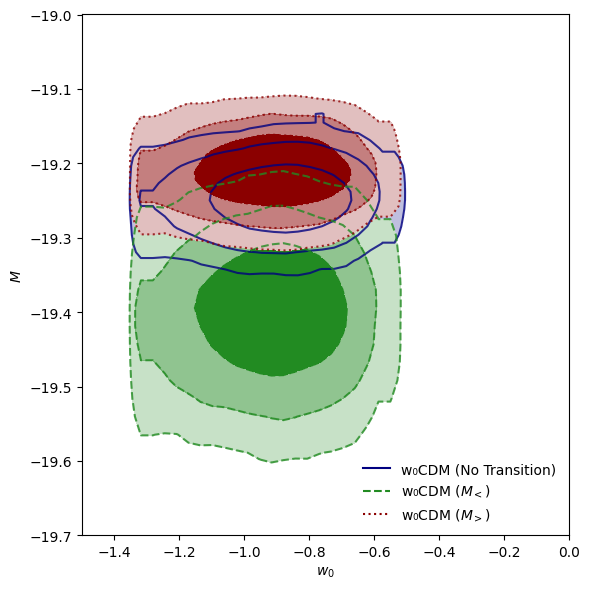

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# --- Load MCMC samples ---
samples_std = np.load("Saved Samples/samples_chain_w0CDM_5000steps.npy")
samples_trans = np.load("samples_chain_w0CDM_transition_5000steps.npy")

# --- Extract relevant parameters ---
# Standard model: M, w0
M_std, w0_std = samples_std[:, 0], samples_std[:, 3]

# Transition model:
# M_low (M<), M_high (M>), w0
M_lt, M_gt = samples_trans[:, 0], samples_trans[:, 1]
w0_tr = samples_trans[:, 4]

# --- Define plot limits ---
w0_range = (-1.5, 0.0)
M_range = (-19.7, -19.0)

# --- Create plot ---
fig, ax = plt.subplots(figsize=(6, 6))

# ---------- Plot 2D contours: w0 vs M ----------
corner.hist2d(w0_std, M_std, ax=ax, plot_datapoints=False,
              fill_contours=True, smooth=0.8,
              levels=(0.6827, 0.9545, 0.9973),
              color="navy",
              contour_kwargs={"linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.3})

corner.hist2d(w0_tr, M_lt, ax=ax, plot_datapoints=False,
              fill_contours=True, smooth=0.8,
              levels=(0.6827, 0.9545, 0.9973),
              color="forestgreen",
              contour_kwargs={"linestyles": "dashed", "linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.2})

corner.hist2d(w0_tr, M_gt, ax=ax, plot_datapoints=False,
              fill_contours=True, smooth=0.8,
              levels=(0.6827, 0.9545, 0.9973),
              color="darkred",
              contour_kwargs={"linestyles": "dotted", "linewidths": 1.5, "alpha": 0.8},
              fill_kwargs={"alpha": 0.2})

# --- Axis settings ---
ax.set_xlim(w0_range)
ax.set_ylim(M_range)
ax.set_xlabel(r"$w_0$")
ax.set_ylabel(r"$M$")

# --- Legend ---
handles = [
    plt.Line2D([], [], color='navy', label="w₀CDM (No Transition)"),
    plt.Line2D([], [], color='forestgreen', linestyle='--', label=r"w₀CDM ($M_{<}$)"),
    plt.Line2D([], [], color='darkred', linestyle=':', label=r"w₀CDM ($M_{>}$)")
]
ax.legend(handles=handles, loc="lower right", frameon=False)

# --- Finalize ---
plt.tight_layout()
plt.savefig("figure_w0_vs_M_comparison.png", dpi=300)
plt.show()


# Nested Sampling | dynesty
## No-Transition

In [5]:
priors_w0CDM = {
    'M': (-20.0, -18.0),
    'H0': (65.0, 78.0),
    'Omega_m': (0.1, 0.8),
    'w0': (-1.3, 0.0)
}

def prior_transform_w0CDM(u):
    """
    u: 1D array with elements in [0, 1]
    Maps to physical parameters using uniform priors for w₀CDM (no transition)
    """
    M_min, M_max = priors_w0CDM['M']
    H0_min, H0_max = priors_w0CDM['H0']
    Om_min, Om_max = priors_w0CDM['Omega_m']
    w0_min, w0_max = priors_w0CDM['w0']
    
    M = M_min + u[0] * (M_max - M_min)
    H0 = H0_min + u[1] * (H0_max - H0_min)
    Omega_m = Om_min + u[2] * (Om_max - Om_min)
    w0 = w0_min + u[3] * (w0_max - w0_min)
    
    return [M, H0, Omega_m, w0]
def chi2_w0CDM(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    """
    Compute chi² for w₀CDM (no transition):
    M, H0, Omega_m, w0
    """
    M, H0, Omega_m, w0 = params

    # Compute the theoretical distance modulus using w₀CDM
    mu_model = mu_theory_w0CDM(z, H0, Omega_m, w0=w0)

    # Compute the residuals (Q vector)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        mB - M - mu_model
    )

    return Q.T @ C_inv @ Q
def log_likelihood_w0CDM(theta):
    """
    Log-likelihood for w₀CDM = -0.5 * χ²
    """
    M, H0, Omega_m, w0 = theta
    chi2 = chi2_w0CDM([M, H0, Omega_m, w0], z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2


In [6]:
import dynesty
import multiprocessing

# Define number of parameters
ndim = 4  # M, H0, Omega_m, w0

# Enable multiprocessing
with multiprocessing.Pool() as pool:
    dsampler_w0 = dynesty.NestedSampler(
        log_likelihood_w0CDM,
        prior_transform_w0CDM,
        ndim=ndim,
        nlive=500,                # Number of live points (tune as needed)
        sample='rwalk',           # Good for multi-modal posteriors
        bound='multi',            # Multi-ellipsoid bounding
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )

    dsampler_w0.run_nested(print_progress=True)
    results_w0CDM = dsampler_w0.results


5763it [1:24:35,  1.14it/s, +500 | bound: 46 | nc: 1 | ncall: 123496 | eff(%):  5.092 | loglstar:   -inf < -761.302 <    inf | logz: -772.091 +/-  0.146 | dlogz:  0.001 >  0.509]


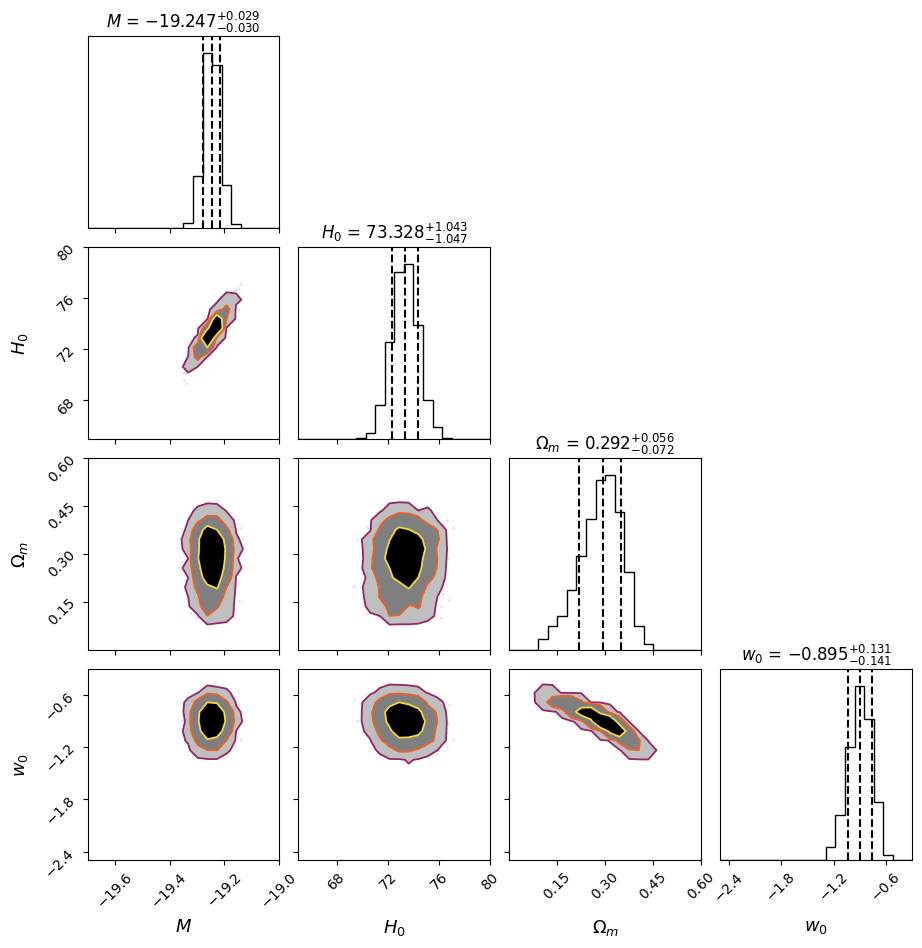

In [7]:
# --- Extract weighted samples from dynesty results ---
samples_w0, weights_w0 = results_w0CDM.samples, np.exp(results_w0CDM.logwt - results_w0CDM.logz[-1])
samples_equal_w0 = dyfunc.resample_equal(samples_w0, weights_w0)

# --- Parameter labels ---
param_labels = [
    r"$M$",
    r"$H_0$",
    r"$\Omega_m$",
    r"$w_0$"
]

# --- Optional: axis ranges (adjust as needed) ---
ranges = [
    (-19.7, -19.0),   # M
    (65, 80),         # H0
    (0.0, 0.6),       # Omega_m
    (-2.5, -0.3)      # w0
]

# --- Contour styling ---
cmap = plt.cm.inferno
levels = [0.68, 0.95, 0.997]
colors = [cmap(x) for x in np.linspace(0.4, 0.9, len(levels))]

# --- Generate corner plot ---
fig = corner.corner(
    samples_equal_w0,
    labels=param_labels,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    range=ranges
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# --- Save and show plot ---
fig.savefig("corner_dynesty_w0CDM.png", dpi=300)
plt.show()

In [6]:
# Load results (assuming you just finished running the sampler)
results_w0CDM = dsampler_w0.results

# Extract samples and log-likelihoods
samples = results_w0CDM.samples       # shape: (n_samples, 4)
logl = results_w0CDM.logl            # log-likelihoods

# MAP: sample with maximum likelihood
map_idx = np.argmax(logl)
map_params = samples[map_idx]

# Median from posterior distribution
median_params = np.median(samples, axis=0)

# Parameter names
param_names = ["M", "H0", "Omega_m", "w0"]
units = ["", "km/s/Mpc", "", ""]

# Display nicely
print("Parameter       MAP Value       Median Value       Unit")
print("-------------------------------------------------------------")
for name, map_val, med_val, unit in zip(param_names, map_params, median_params, units):
    print(f"{name:<15} {map_val:>10.4f}       {med_val:>10.4f}       {unit}")


Parameter       MAP Value       Median Value       Unit
-------------------------------------------------------------
M                 -19.2498         -19.2457       
H0                 73.2347          72.9516       km/s/Mpc
Omega_m             0.2981           0.3205       
w0                 -0.9146          -0.8667       


In [7]:
from dynesty import utils as dyfunc

# Get posterior-weighted samples and weights
samples = results_w0CDM.samples
weights = np.exp(results_w0CDM.logwt - results_w0CDM.logz[-1])
posterior_samples = dyfunc.resample_equal(samples, weights)

# Save for later use or plotting
np.save("posterior_samples_w0CDM.npy", posterior_samples)

# Extract log-evidence (marginal likelihood) and its uncertainty
logZ = results_w0CDM.logz[-1]
logZerr = results_w0CDM.logzerr[-1]

# Print result
print(f"logZ (w0CDM no transition): {logZ:.2f} ± {logZerr:.2f}")


logZ (w0CDM no transition): -772.36 ± 0.25


## Transition in $M$

In [7]:
priors_w0CDM_transition = {
    'M_low': (-20.0, -18.0),
    'M_high': (-20.0, -18.0),
    'H0': (65.0, 78.0),
    'Omega_m': (0.1, 0.8),
    'w0': (-1.3, 0.0),
    'd_crit': (15.0, 25.0)
}

def prior_transform_w0CDM_transition(u):
    """
    Maps unit cube [0,1]^6 → physical parameter space for w₀CDM with M transition
    """
    keys = list(priors_w0CDM_transition.keys())
    theta = []
    for i in range(6):
        low, high = priors_w0CDM_transition[keys[i]]
        theta.append(low + u[i] * (high - low))
    return theta

def chi2_w0CDM_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M_low, M_high, H0, Omega_m, w0, d_crit = params

    # Theoretical distance modulus from w0CDM
    mu_model = mu_theory_w0CDM(z, H0, Omega_m, w0)

    # Use apparent magnitude to calculate SH0ES-based distance modulus
    mu_SH0ES = mB + 19.253  # SH0ES fixed M = -19.253
    mu_crit = 5 * np.log10(d_crit) + 25

    # Assign M_low or M_high depending on location relative to d_crit
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    # Construct Q vector
    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        mB - M_used - mu_model
    )

    return Q.T @ C_inv @ Q

def log_likelihood_w0CDM_transition(theta):
    """
    Log-likelihood = -0.5 * chi² for w₀CDM with transition in M
    """
    chi2 = chi2_w0CDM_transition(theta, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2

In [8]:
# Number of parameters: M_low, M_high, H0, Omega_m, w0, d_crit
ndim = 6

# --- Run NestedSampler with multiprocessing ---
with multiprocessing.Pool() as pool:
    dsampler_w0CDM_trans = dynesty.NestedSampler(
        log_likelihood_w0CDM_transition,
        prior_transform_w0CDM_transition,
        ndim=ndim,
        nlive=250,
        sample='rwalk',
        bound='multi',
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )

    dsampler_w0CDM_trans.run_nested(print_progress=True)
    results_w0CDM_transition = dsampler_w0CDM_trans.results

4581it [1:18:02,  1.02s/it, +250 | bound: 45 | nc: 1 | ncall: 119878 | eff(%):  4.038 | loglstar:   -inf < -751.685 <    inf | logz: -768.687 +/-  0.243 | dlogz:  0.001 >  0.259]


In [9]:
from dynesty import utils as dyfunc
import numpy as np

# Extract posterior-weighted samples and weights
samples = results_w0CDM_transition.samples
weights = np.exp(results_w0CDM_transition.logwt - results_w0CDM_transition.logz[-1])
posterior_samples = dyfunc.resample_equal(samples, weights)

# Save posterior samples for later plotting
np.save("posterior_samples_w0CDM_transition.npy", posterior_samples)

# Extract log-evidence (logZ) and its error
logZ_trans = results_w0CDM_transition.logz[-1]
logZerr_trans = results_w0CDM_transition.logzerr[-1]

# Print result
print(f"logZ (w0CDM with transition): {logZ_trans:.2f} ± {logZerr_trans:.2f}")


logZ (w0CDM with transition): -768.69 ± 0.31


In [10]:
import numpy as np

# Known result from previous run
logZ_no = -772.36
logZerr_no = 0.25

# From current w₀CDM + transition model run
logZ_trans = results_w0CDM_transition.logz[-1]
logZerr_trans = results_w0CDM_transition.logzerr[-1]

# Compute ΔlogZ and uncertainty
delta_logZ = logZ_trans - logZ_no
delta_logZ_err = np.sqrt(logZerr_trans**2 + logZerr_no**2)

# Print results
print("Bayesian Model Comparison:")
print("--------------------------")
print(f"logZ (w0CDM no transition)     = {logZ_no:.2f} ± {logZerr_no:.2f}")
print(f"logZ (w0CDM with transition)   = {logZ_trans:.2f} ± {logZerr_trans:.2f}")
print(f"ΔlogZ (transition - no trans)  = {delta_logZ:.2f} ± {delta_logZ_err:.2f}")

# Jeffreys' scale interpretation
if delta_logZ < 1:
    interpretation = "Inconclusive preference"
elif delta_logZ < 2.5:
    interpretation = "Weak evidence for transition model"
elif delta_logZ < 5:
    interpretation = "Moderate evidence for transition model"
else:
    interpretation = "Strong evidence for transition model"

print(f"Interpretation: {interpretation}")


Bayesian Model Comparison:
--------------------------
logZ (w0CDM no transition)     = -772.36 ± 0.25
logZ (w0CDM with transition)   = -768.69 ± 0.31
ΔlogZ (transition - no trans)  = 3.67 ± 0.40
Interpretation: Moderate evidence for transition model


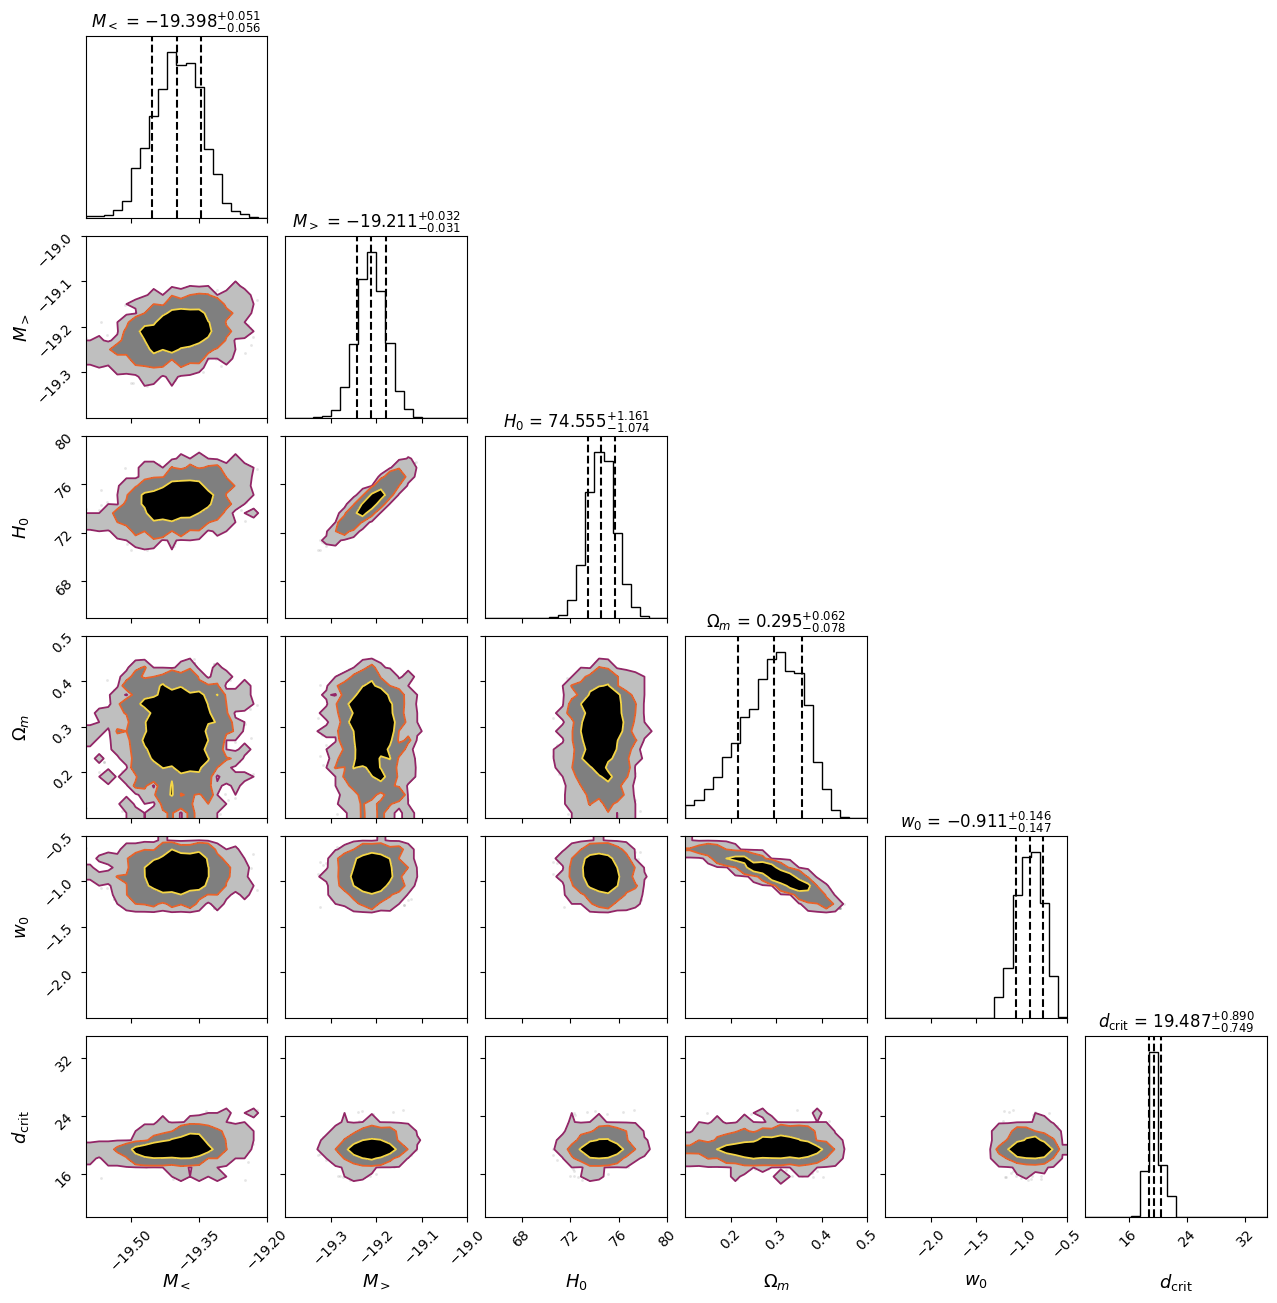

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from dynesty import utils as dyfunc

# --- Extract posterior samples from dynesty ---
samples_dynesty = results_w0CDM_transition.samples
weights = np.exp(results_w0CDM_transition.logwt - results_w0CDM_transition.logz[-1])
samples_equal = dyfunc.resample_equal(samples_dynesty, weights)

# --- Parameter labels for w₀CDM + transition model ---
param_labels = [
    r"$M_<$",
    r"$M_>$",
    r"$H_0$",
    r"$\Omega_m$",
    r"$w_0$",
    r"$d_{\rm crit}$"
]

# --- Contour styling ---
cmap = plt.colormaps["inferno"]
levels = [0.68, 0.95, 0.997]
colors = [cmap(x) for x in np.linspace(0.4, 0.9, len(levels))]

# --- Axis ranges (adjust as needed) ---
ranges = [
    (-19.6, -19.2),   # M_<
    (-19.4, -19.0),   # M_>
    (65, 80),         # H0
    (0.1, 0.5),       # Omega_m
    (-2.5, -0.5),     # w0
    (10, 35)          # d_crit [Mpc]
]

# --- Generate corner plot ---
fig = corner.corner(
    samples_equal,
    labels=param_labels,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    range=ranges
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# --- Save plot ---
fig.savefig("corner_dynesty_w0CDM_transition.png", dpi=300)
plt.show()


In [13]:
print("\nPosterior median ±1σ for each parameter:")
for i, label in enumerate(param_labels):
    q16, q50, q84 = np.percentile(samples_equal[:, i], [16, 50, 84])
    err_minus, err_plus = q50 - q16, q84 - q50
    print(f"{label} = {q50:.3f} (+{err_plus:.3f}/-{err_minus:.3f})")


Posterior median ±1σ for each parameter:
$M_<$ = -19.398 (+0.051/-0.056)
$M_>$ = -19.211 (+0.032/-0.031)
$H_0$ = 74.555 (+1.161/-1.074)
$\Omega_m$ = 0.295 (+0.062/-0.078)
$w_0$ = -0.911 (+0.146/-0.147)
$d_{\rm crit}$ = 19.487 (+0.890/-0.749)
